In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [3]:
import numpy as np
import ot
import os
import matplotlib.pyplot as plt
from joint_OT_mapping_linear_classreg import joint_OT_mapping_linear, compute_joint_OT_mapping
import torch
from einops import rearrange
from MNISTDigitDataset import MNISTDigitDataset
from torchvision import transforms
from visualization_utils import plot_pca_for_arrays, plot_images, visualize_barycenter_diracs, plot_flattened_images
from data_utils import setup_MNIST_dataset
from SVM_utils import test_svm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu')
print('Using device: {}'.format(device))

Using device: cpu


In [4]:
%load_ext autoreload
%autoreload 2

# Data setup

In [52]:
# Hyperparameters
dataset = "MNIST"
n_samples = 50
noise_scale = 0.4
dtype = torch.float32
digits = [0, 1]
log = True
n_sites = 2

In [53]:
# X_train_original and X_train_L have shape (n_digits, n_samples, 784)
X_train_original, ys, X_train_L = setup_MNIST_dataset(
    root="/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw",
    digits=digits,
    indices=list(np.arange(start=0, stop=n_samples)),
    device=device,
    noise_scale=noise_scale,
)

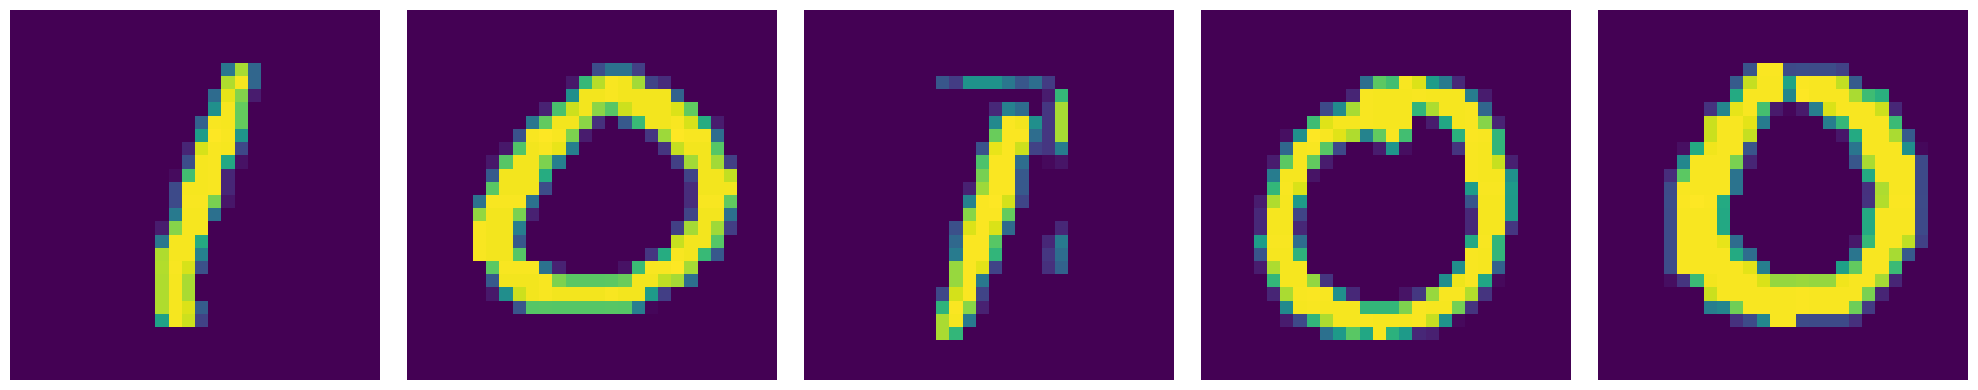

In [54]:
plot_images(X_train_original)
plt.show()

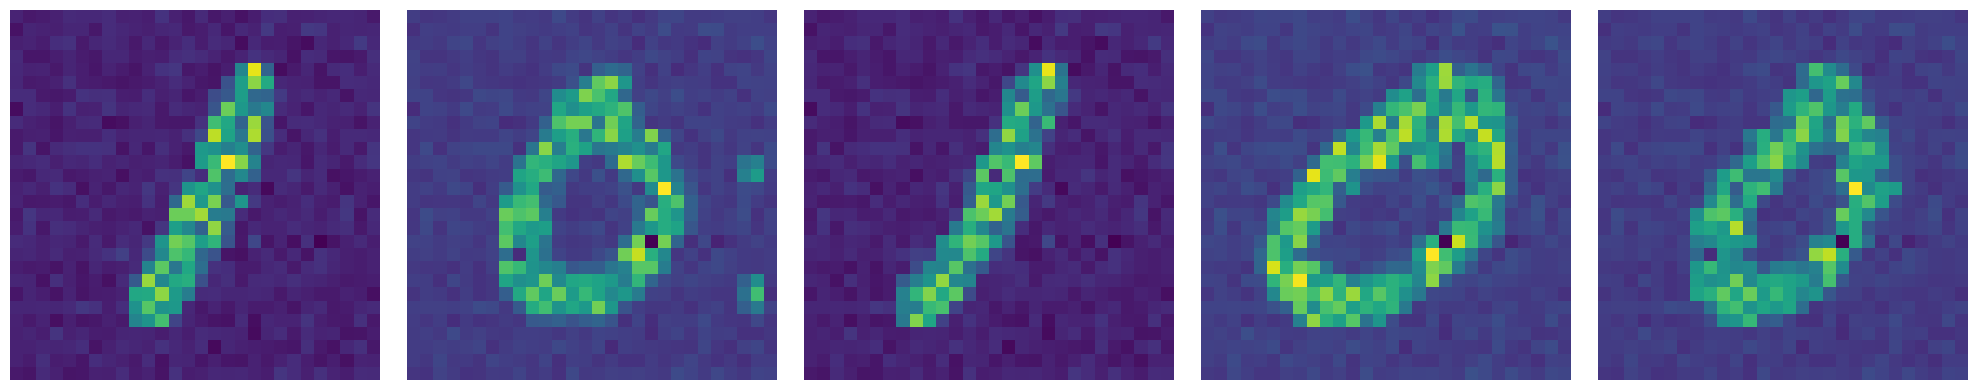

In [55]:
plot_images(X_train_L)
plt.show()

We now consider measures. Each dataset will be considered a measure:

$\mu = \sum a_i \delta_{xi}$

meaning that every image in the dataset is a dirac delta at point $x$, with probability mass of $a_i$. $x$ is the location of the dirac, and it has the coordinates of the flattened image. 

Set the probability masses to uniform 1/n

In [56]:
a_i = 1.0 / (n_sites * X_train_original.shape[0])
w_i = torch.ones(size=(X_train_original.shape[0],), dtype=torch.int, device=device) * a_i

In [57]:
w_i.shape, a_i

(torch.Size([100]), 0.005)

# Compute the free-support Sinkhorn barycenter of the measures

In [58]:
torch.stack((X_train_original, X_train_L)).shape

torch.Size([2, 100, 784])

In [84]:
recompute = True

if not recompute and os.path.exists('barycenter.npy'):
    barycenter = np.load('barycenter.npy')
    print('Barycenter loaded')
else:
    barycenter, log_dict = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=torch.stack((X_train_original, X_train_L)),
        measures_weights=[w_i] * n_sites,
        X_init=torch.randn(
            (X_train_original.shape[0] * n_sites, X_train_original.shape[1]),
            dtype=torch.float32,
            device=device,
        ),
        reg=25.0,
        b=torch.ones((X_train_original.shape[0] * n_sites, ), dtype=torch.float32, device=device) / (X_train_original.shape[0] * n_sites),
        numItermax=2e15,
        numInnerItermax=100000,
        verbose=True,
        stopThr=1e-7,
        log=True,
    )
    # Save barycenter if kernel needs to be restarted
    np.save('barycenter.npy', barycenter)

iteration %d, displacement_square_norm=%f
 0 tensor(170526.7656)
iteration %d, displacement_square_norm=%f
 1 tensor(45435.1250)
iteration %d, displacement_square_norm=%f
 2 tensor(9977.3193)
iteration %d, displacement_square_norm=%f
 3 tensor(4448.5752)
iteration %d, displacement_square_norm=%f
 4 tensor(1343.8765)
iteration %d, displacement_square_norm=%f
 5 tensor(240.4046)
iteration %d, displacement_square_norm=%f
 6 tensor(128.9982)
iteration %d, displacement_square_norm=%f
 7 tensor(85.7224)
iteration %d, displacement_square_norm=%f
 8 tensor(65.7401)
iteration %d, displacement_square_norm=%f
 9 tensor(67.3190)
iteration %d, displacement_square_norm=%f
 10 tensor(46.8769)
iteration %d, displacement_square_norm=%f
 11 tensor(21.4482)
iteration %d, displacement_square_norm=%f
 12 tensor(6.9459)
iteration %d, displacement_square_norm=%f
 13 tensor(2.9437)
iteration %d, displacement_square_norm=%f
 14 tensor(1.9411)
iteration %d, displacement_square_norm=%f
 15 tensor(1.7166)
iterati

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 121
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


iteration %d, displacement_square_norm=%f
 19 tensor(0.2065)
iteration %d, displacement_square_norm=%f
 20 tensor(0.1149)
iteration %d, displacement_square_norm=%f
 21 tensor(0.0563)
iteration %d, displacement_square_norm=%f
 22 tensor(0.0269)
iteration %d, displacement_square_norm=%f
 23 tensor(0.0149)
iteration %d, displacement_square_norm=%f
 24 tensor(0.0108)
iteration %d, displacement_square_norm=%f
 25 tensor(0.0099)
iteration %d, displacement_square_norm=%f
 26 tensor(0.0102)
iteration %d, displacement_square_norm=%f
 27 tensor(0.0110)
iteration %d, displacement_square_norm=%f
 28 tensor(0.0121)
iteration %d, displacement_square_norm=%f
 29 tensor(0.0133)
iteration %d, displacement_square_norm=%f
 30 tensor(0.0144)
iteration %d, displacement_square_norm=%f
 31 tensor(0.0155)
iteration %d, displacement_square_norm=%f
 32 tensor(0.0162)
iteration %d, displacement_square_norm=%f
 33 tensor(0.0167)
iteration %d, displacement_square_norm=%f
 34 tensor(0.0166)
iteration %d, displaceme

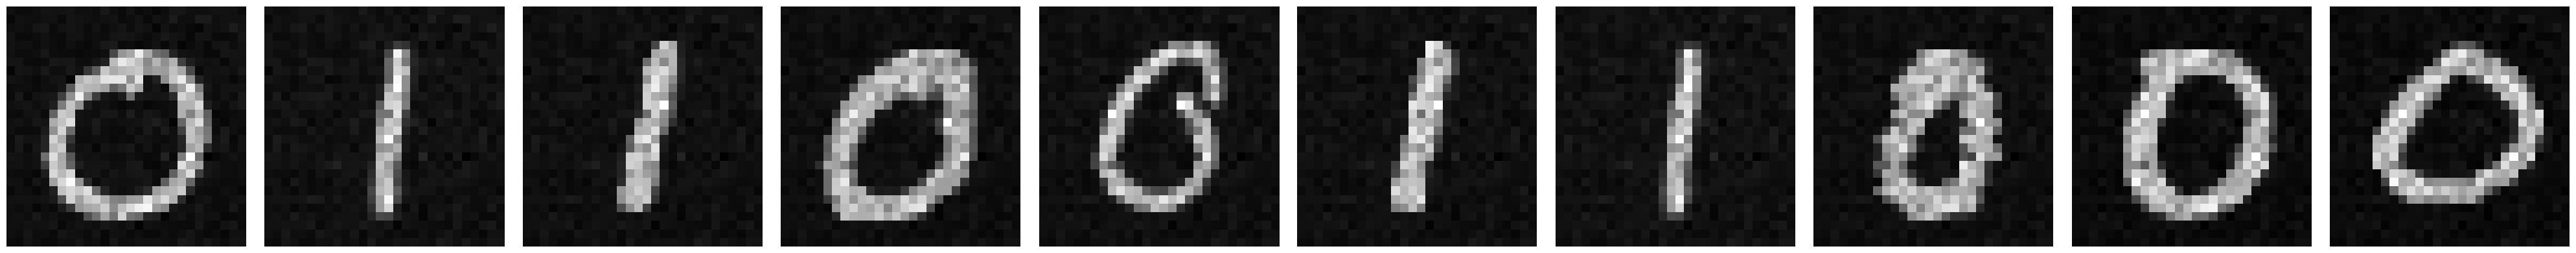

In [85]:
visualize_barycenter_diracs(barycenter=barycenter, num_images=10, random_seed=40)
plt.show()

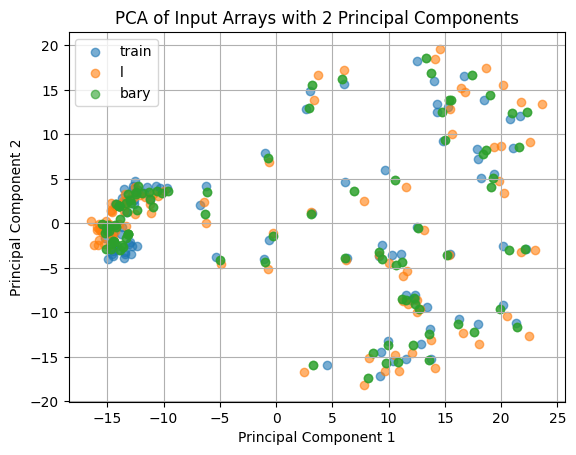

In [89]:
plot_pca_for_arrays([X_train_original, X_train_L, barycenter], n_components=2, labels=['train', 'l','bary'])
plt.show()

# Compute the Kantorovich and Monge solutions jointly
From the different measures to the barycenter.

- Kantorovich: One measure has 1000 dirac deltas at positions $x_i \in \mathbb{R}^{784}$, therefore the coupling matrices have shape $784 \times 784$.
- Monge: The map T is to be found as a linear transformation (represented by matrix $L \in \mathbb{R}^{784 \times 784}$) with a bias term (which makes it a matrix $\mathbb{R}^{785 \times 784}$).

In [62]:
barycenter = torch.tensor(barycenter, device=device, dtype=dtype)

/var/folders/z_/7fqm4zqs11zdv7cm41c6w_pc0000gn/T/ipykernel_26948/3723891081.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  barycenter = torch.tensor(barycenter, device=device, dtype=dtype)


In [63]:
barycenter.shape, X_train_original.shape

(torch.Size([200, 784]), torch.Size([100, 784]))

In [65]:
G_1, L_1_0, loss = compute_joint_OT_mapping(
        xs=X_train_original, xt=barycenter, ys=ys, yt=ys, method="linear"
    )
L1 = L_1_0[0:784]
b1 = L_1_0[784]

It.  |Loss        |Delta loss
--------------------------------
    0|4.424549e+03|0.000000e+00
    1|4.424546e+03|-7.725010e-07
    2|4.424544e+03|-4.414295e-07
    3|4.424541e+03|-7.725019e-07
    4|4.424539e+03|-4.414300e-07
    5|4.424536e+03|-5.517878e-07
    6|4.424533e+03|-6.621457e-07
    7|4.424531e+03|-4.414308e-07
    8|4.424528e+03|-6.621464e-07
    9|4.424528e+03|0.000000e+00


In [66]:
G_2, L_2_0, loss_2 = compute_joint_OT_mapping(
        xs=X_train_original, xt=barycenter, ys=ys, yt=ys, method="linear"
    )
L2 = L_2_0[0:784]
b2 = L_2_0[784]

It.  |Loss        |Delta loss
--------------------------------
    0|4.424549e+03|0.000000e+00
    1|4.424546e+03|-7.725010e-07
    2|4.424544e+03|-4.414295e-07
    3|4.424541e+03|-7.725019e-07
    4|4.424539e+03|-4.414300e-07
    5|4.424536e+03|-5.517878e-07
    6|4.424533e+03|-6.621457e-07
    7|4.424531e+03|-4.414308e-07
    8|4.424528e+03|-6.621464e-07
    9|4.424528e+03|0.000000e+00


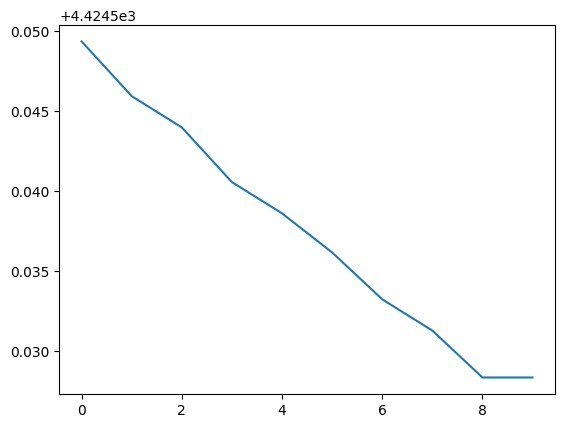

In [67]:
plt.plot(loss['loss'])
plt.show()

In [69]:
G_1.shape, L1.shape

(torch.Size([100, 200]), torch.Size([784, 784]))

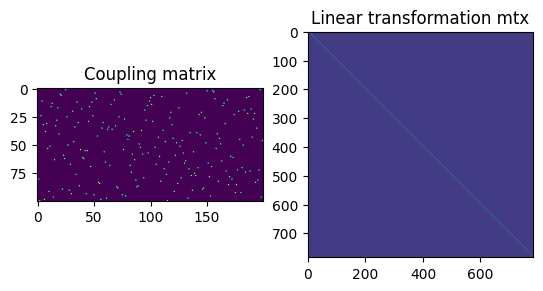

In [70]:
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(G_1)
axarr[0].set_title('Coupling matrix')
axarr[1].imshow(L1)
axarr[1].set_title('Linear transformation mtx')
plt.show()

# Assess the performance with a classifier

Train classifier

In [102]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", C=1.0, class_weight='balanced', random_state=42, verbose=True)
model.fit(X=barycenter, y=yt)

[LibSVM]*
optimization finished, #iter = 74
obj = -73.716730, rho = -0.295107
nSV = 98, nBSV = 82
Total nSV = 98


SVC(class_weight='balanced', random_state=42, verbose=True)

In [103]:
assert model.fit_status_ == 0

Test the fitted SVM on the train set

{'accuracy': 0.799999992,
 'recall': 0.8399999832000004,
 'precision': 0.7777777633744859}

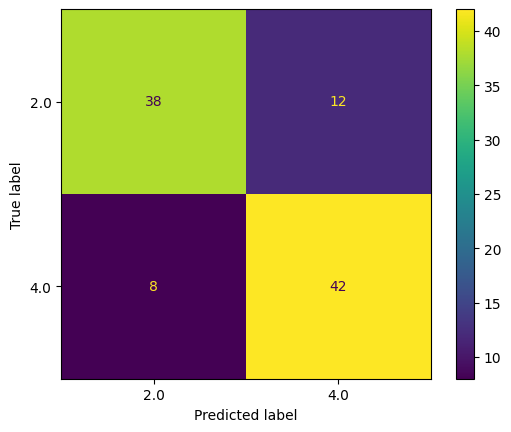

In [139]:
test_svm(model, xt, yt)

Test the SVM on the unmodified source 1

{'accuracy': 0.4599999954000001,
 'recall': 0.4199999916000002,
 'precision': 0.4565217292060494}

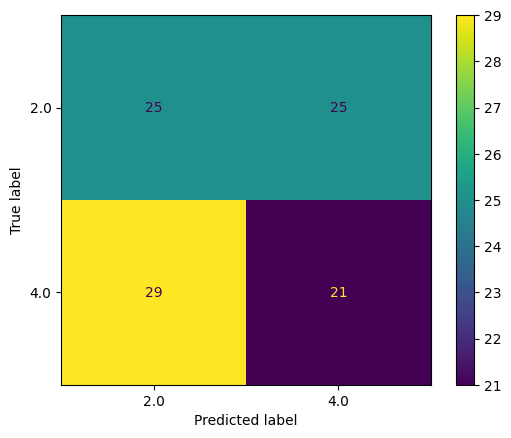

In [137]:
test_svm(model, xs1, ys1, L=None, b=None)

Test the SVM on the modified source 1

{'accuracy': 0.8299999917,
 'recall': 0.8999999820000004,
 'precision': 0.7894736703601111}

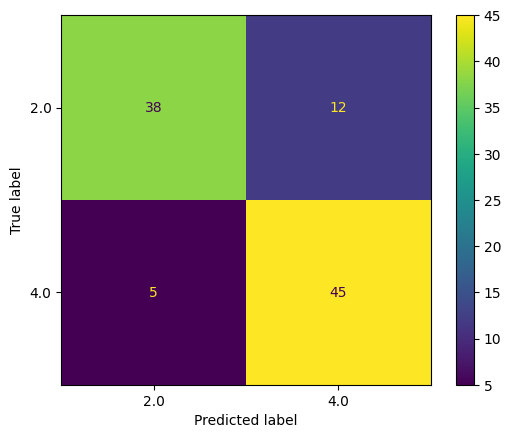

In [135]:
test_svm(model, xs1, ys1, L[0:784], L[784])

Test it on unforseen examples from source 1

In [127]:
new_indices = np.arange(start=n_samples, stop=n_samples * 2, dtype=int)

X_2_new = np.array(ds_2.__getitem__(new_indices)[0])
X_4_new = np.array(ds_4.__getitem__(new_indices)[0])

X_2_new = torch.tensor(X_2_new, dtype=torch.float32, device=device)
X_4_new = torch.tensor(X_4_new, dtype=torch.float32, device=device)

xs1_new = rearrange(torch.stack(
    [X_2_new, X_4_new],
    dim=0),
    'a b c -> (a b) c')

ys1_new = rearrange(torch.stack([torch.ones((n_samples,), device=device) * 2, torch.ones((n_samples,), device=device) * 4]), 'a b -> (a b)')

{'accuracy': 0.4199999958,
 'recall': 0.23999999520000012,
 'precision': 0.3749999882812504}

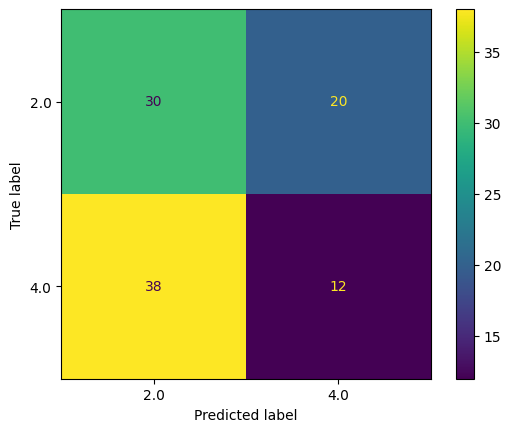

In [133]:
test_svm(model, xs1_new, ys1_new, L=None, b=None)

{'accuracy': 0.6399999936,
 'recall': 0.6399999872000003,
 'precision': 0.6399999872000003}

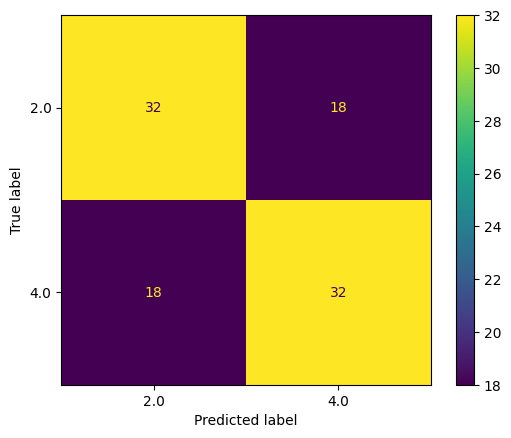

In [159]:
test_svm(model=model, x=xs1_new, y=ys1_new, L=L[0:784], b=L[784])